In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax

# Basis Functions

Basis functions are used throughout data science to approximate a function.  Typical applications are for smoothing data or simplifying further math.  The basic idea is to pick a set of functions $\{g_i\}$ that can be used to express another function, $f$, in an expansion.  We will restrict this discussion to functions of one variable and linear coefficients in the expansion.  This allows us to write $f(x)$ as a linear combination of functions $\{g_i(x)\}$,

$f(x) = \sum_{i=0}^\infty c_ig_i(x)$.

This equality is only exact for certain sets of functions.  This is analagous to basis sets of vector spaces.  Rather than go into the details of the math of expansions and spanning spaces, we will provide two standard examples of $\{g_i\}$s: polynomials and gaussians.

## Polynomial basis functions

The idea is to express some function $f(x)$ as a linear combination of polynomials.  This is exact in the limit of infinite powers.  This can be expressed as $g_i(x) = x^i$.  Thus we get

$f(x) = \sum_{i=0}^\infty c_ix^i = c_0 + c_1x + c_2x^2 + c_3x^3...$.

If we truncate this expansion at $i=1$ we get a linear approximation of $f$,

$f(x) \approx c_0 + c_1x$.

Fitting of these linear coefficients, $c_0$ and $c_1$, is commonly reffered to as linear regression.

As an example of linear regression we will utilize a concoted data set and then fit these points to a line.  Each "data point" represents an ordered pair $(x,f(x))$.  If we have two data points we would have two depedent linear equations

$ f(x_1) = c_0 + c_1x_1 \\ f(x_2) = c_0 + c_1x_2.$

With only two points, we can solve for $c_0$ and $c_1$ exactly.  This simply equates to two points determine a line.  Note that this can also be expressed as a matrix equation:

$\begin{bmatrix} f(x_1) \\ f(x_2) \end{bmatrix} = \begin{bmatrix} c_0 + c_1x_1 \\ c_0 + c_1x_2 \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \end{bmatrix}  \begin{bmatrix} c_0 \\ c_1 \end{bmatrix} $.

The right-hand most expression is referred to as the coefficient matrix multiplied by the solution vector.  The solution vector can be solved for by left multiplying the expression by the inverse of the coefficient matrix

$\begin{bmatrix} c_0 \\ c_1 \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \end{bmatrix}^{-1}\begin{bmatrix} f(x_1) \\ f(x_2)\end{bmatrix}$.

For an overdetermined set of linear equations we can solve for the solution vector (set of coefficients $\{c_i\}$) using a least squares algorithm.  The problem is usually set up as

$\mathbf{A}\mathbf{x} = \mathbf{b}$, 

where $\mathbf{A}$ is the coefficient matrix, $\mathbf{x}$ is the solution vector and $\mathbf{b}$ is the $f(x)$ vector similar to above.  

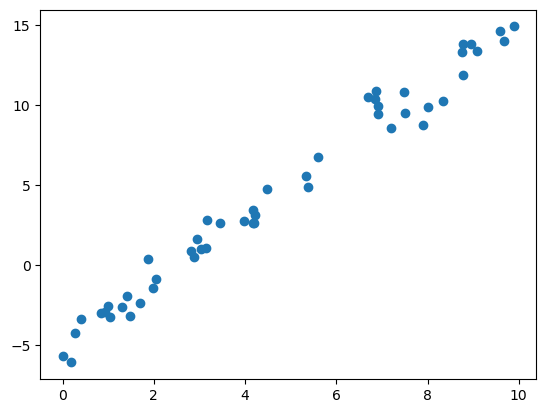

In [3]:
# first generate a "data set"
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

/var/folders/t8/kw0bwdw15_g0pj38_ntzjgyc0000gp/T/ipykernel_58210/224043109.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  cs = np.linalg.lstsq(A,y)[0]


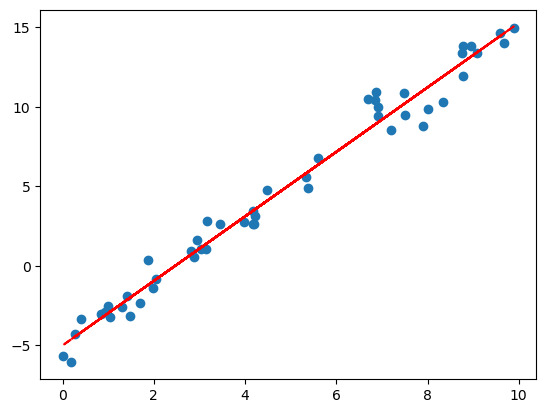

In [4]:
# now we need to generate the coefficient matrix
A = np.stack((x,np.ones(x.size)),axis=1)
# use numpy least squares routine
cs = np.linalg.lstsq(A,y)[0]
plt.scatter(x, y)
plt.plot(x,cs[0]*x+cs[1],'r--')

We could truncate past second order to get a polynomial fit.   A general Nth order polynomial approximation for $f$ is given as

$f(x) \approx \sum_{i=0}^N c_ix^i = c_0 + c_1x + c_2x^2 + c_3x^3 + ... + c_Nx^N$.


/var/folders/t8/kw0bwdw15_g0pj38_ntzjgyc0000gp/T/ipykernel_58210/2434224687.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  cs = np.linalg.lstsq(A,y)[0]


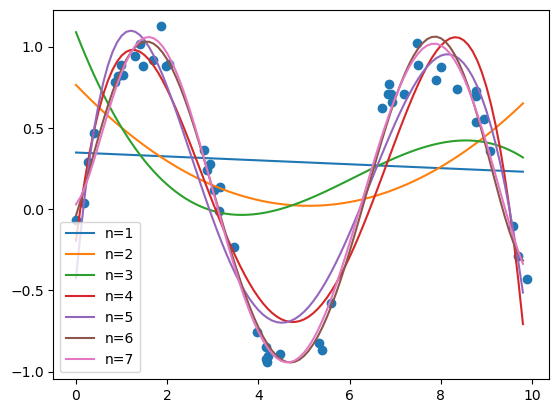

In [5]:
# code to do successive polynomial fits
maxN = 7 # maximum order of polynomial - change to increase or decrease maximum order of polynomial
# polynomial function compute polynomial value of x using coefficient cs
def poly(x,cs):
    f=0.0
    for i in range(cs.size):
        f += cs[i]*x**i
    return f
# generate sinusoidal "data"
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
# plot data
plt.scatter(x, y)
xfit = np.arange(np.amin(x),np.amax(x),0.1)
# perform successive polynomial fits
A = np.ones(x.size)
for i in range(1,maxN+1):
    A = np.column_stack((A,np.power(x,i)))
    cs = np.linalg.lstsq(A,y)[0]
    label = "n="+str(i)
    plt.plot(xfit, poly(xfit,cs),label=label)
plt.legend()

## Gaussian basis functions

Instead of using polynomials we can use gaussians.  Again, we need to truncate to $N$ gaussians and these will be centered at different positions in x. This can be expressed as

$f(x) \approx \sum_{i=0}^N c_ig_i(x)$

where

$g_i(x) = e^{-\alpha (x-x_i)^2}$

and $\alpha$ is the inverse of the spread of the gaussian and $x_i$ is the center of the gaussian.


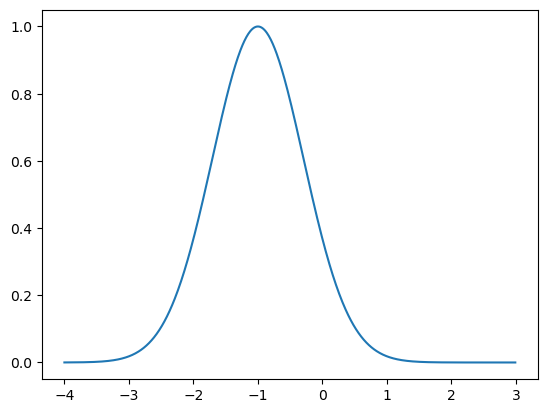

In [6]:
# plot a gaussian
# alpha is related to the spread of gaussian
alpha = 1.0

# gaussian function
def gauss(x,xi,alpha):
    return np.exp(-alpha*(x-xi)**2)

xi = -1.0
xs = np.arange(-4,3,0.01)
plt.plot(xs,gauss(xs,xi,alpha))

/var/folders/t8/kw0bwdw15_g0pj38_ntzjgyc0000gp/T/ipykernel_58210/3314094945.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  cs = np.linalg.lstsq(A,y)[0]


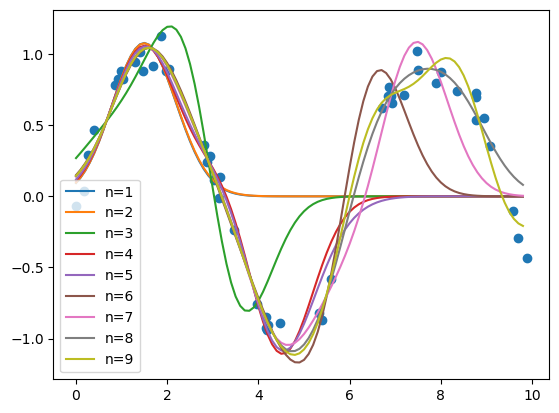

In [7]:
# fit "data" to guassians
# number of gaussians
N = 10
def gauss_sum(x,cs,xis,alpha):
    f = 0.
    for i in range(cs.size):
        f += cs[i]*gauss(x,xis[i],alpha)
    return f

# generate sinusoidal "data"
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
# plot data
plt.scatter(x, y)

# spacing of gaussians
deltaX = (np.amax(x)-np.amin(x))/N
xMin = np.amin(x) 
xis = np.empty(N,dtype=float)
for i in range(N):
    xis[i] = xMin+(i+0.5)*deltaX
# x values for plotting gaussians 
xfit = np.arange(np.amin(x),np.amax(x),0.1)

# make coefficient matrix for gaussian values
A = gauss(x,xis[0],alpha)
for i in range(1,N):
    A = np.column_stack((A,gauss(x,xis[i],alpha)))
    cs = np.linalg.lstsq(A,y)[0]
    label = "n="+str(i)
    plt.plot(xfit, gauss_sum(xfit,cs,xis,alpha),label=label)
plt.legend()

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

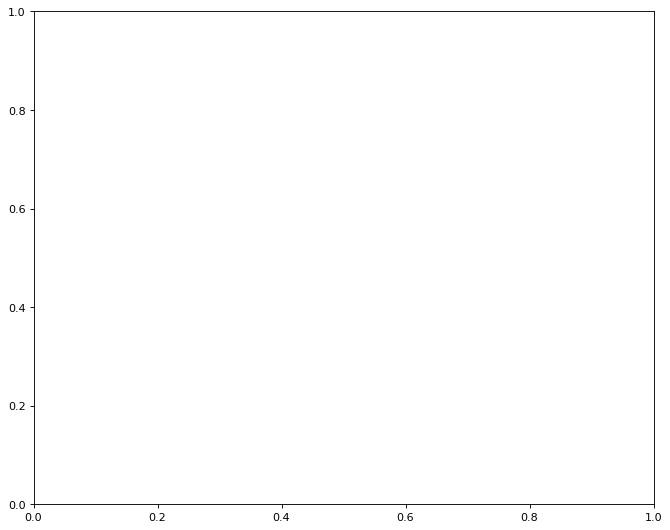

In [8]:
# initialize a figure
ax = define_figure(xlabel="$x$",ylabel="$f(x)$")
ax.scatter(x, y)
ax.plot(xfit, gauss_sum(xfit,cs,xis,alpha))
for i in range(1,N):
    label = "i="+str(i)
    ax.fill_between(xfit,cs[i]*gauss(xfit,xis[i],alpha),alpha=0.25,label=label)
plt.legend()